### Neshyba, 2023


# Integrated kinetic-molecular evaluation of the reversible expansion of an ideal gas

## Introduction
This CGI builds on our previous question, what's going on at the molecular level when we carry out an isothermal reversible expansion of a gas? Here, however, we'll extend our previous results to finite (as opposed to infinitessimal) changes in volume. 


## Numerical integration

We argued previously that the kinetic-molecular formula for the inflow of heat during an infinitessimally small expansion is given by $dq_{kinetic} = -Z \times \delta KE \times A \times dt$, which simplified to $dq_{kinetic,simplified} =  n M v^2 {dV \over V}$. For an expansion that's too big to be considered infinitessimally small, we'll need to add up a series of $dq_{kinetic}$ values until the gas has expanded to our final, desired volume. To do this numerically, we'd write this as

$$
q_{kinetic,numerical} \approx \sum_{V_{init}}^{V_{final}} n M v^2 {dV \over V} \ \ \ \ (1)
$$

A few notes about this equation. First, this is easy to do in Python -- it's what Numpy's np.sum function does. Second, in doing such a sum, we'd want to be sure that each term in the sum is small enough that it could be considered a good approximation to a truely infinitessimal quantity. (That's the sense we intended previously, when we said that $dt$ and $dx$ need to be "small.") Third, in constructing such a sum, we'd need to make sure that the  volume in the denominator is updated for each step. We're just mentioning this because we forgot to do that the first time through this. 

## Analytical integration

If a summation really does contain infinitessimal quantities, we should be able to express it in terms of calculus, right? In other words, the summation in Eq. 1 would be expressed as 

$$
q_{kinetic,analytical} = \int_{V_{init}}^{V_{final}} n M v^2 {dV \over V} \ \ \ \ (2)
$$

To evaluate this integral, you'll find it convenient to pull out of the integral anything that remains constant over the course of the expansion of the gas. Obviously, $n$ and and $M$ could come out. But do we get to pull $v^2$ out too? The answer to this last question hinges on the question of isothermality: if we're insisting that enough heat comes in during the process, such that the gas keeps the same temperature throughout the expansion, that implies something about $v^2$.

## Analytical integration of our thermodynamic formua

We said before that, according to Thermodynamics, the infinessimal work done by an expanding ideal gas, $dw = -P_{ex}dV$, under isothermal and reversible conditions, and invoking the 1st Law, translates to $dq_{thermo} = nRT {dV \over V}$. For an expansion over many such steps, we'd want to integrate over $V$, 

$$
q_{thermo} = \int_{V_{init}}^{V_{final}} nRT {dV \over V}  \ \ \ \ (3)
$$

## The idea of this exericse
A test of the kinetic-molecular theory laid out above would, naturally, be to evaluate whether Eqs. 1, 2, and 3 give (close to) the same answers. If so, it adds support to the notion that the heat that flows into an expanding gas is compensating for the reduction in the kinetic energy of molecules hitting the receding wall.

## Learning goals
The main learning goals of this exercise are 
1. I can show that integrated forms of the infinitessimal movements of heat matche predictions using the the 1st Law of Thermodynamics.
1. I know how to set up loops for the purpose of numerical integration.

In [1]:
import pint; from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
import matplotlib.pyplot as plt
import PchemLibrary as PL
%matplotlib notebook

In [2]:
# Constants
R = AssignQuantity(8.314,'joule/mol/K')
NA = AssignQuantity(6.02e23,'1/mol')
T = AssignQuantity(293,'K')
n = AssignQuantity(1,'mol')

# We're assuming O2 gas here
M = AssignQuantity(32,'g/mol')

### Kinetic theory associated with isothermal processes
The average kinetic energy in the x-direction, according to the equipartition theorem, is $KE = {1 \over 2}Mv^2$, where $M$ is the mass of a mole of molecules. Use that in the cell below to evaluate the average kinetic energy of a mole of our gas molecules, and then compute the RMS speed associated with that average.

In [3]:
# Average kinetic energy in the x-direction, using the equipartition theorem
### BEGIN SOLUTION
KE = 0.5*R*T;
KE.ito('kjoule/mol')
print(KE)
### END SOLUTION

# RMS speed associated with that average
### BEGIN SOLUTION
v = (2/M*KE)**.5
v.ito('m/s')
print(v)
### END SOLUTION

1.2180010000000001 kilojoule / mole
275.90770648896347 meter / second


### Specifying the initial state of our gas
In the cell below, we specify the initial state of our gas, and the box it's in. 

Initial volume =  24.000000000000007 decimeter ** 3
Initial distance in the x-direction =  5 decimeter
Sides of the wall =  2.1908902300206647 decimeter
dx =  0.2 decimeter
Final distance in the x-direction =  9.0 decimeter
Increase in volume =  19.200000000000006 decimeter ** 3
Final volume =  43.20000000000002 decimeter ** 3


<IPython.core.display.Javascript object>


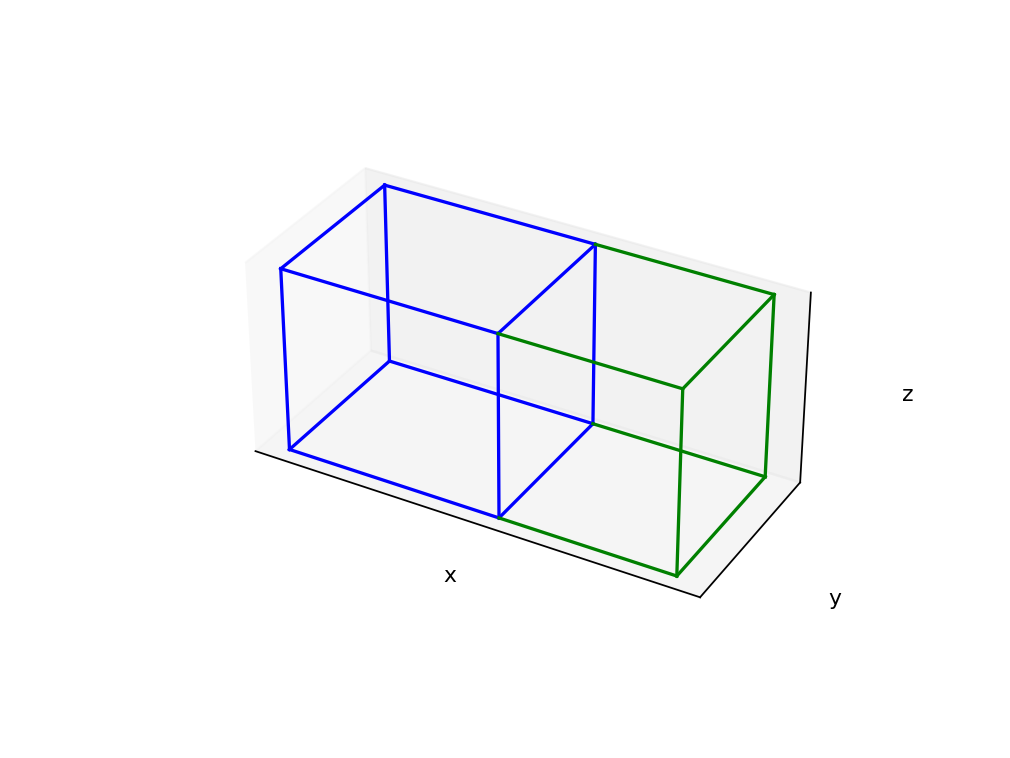

In [4]:
# Specify the initial volume of our gas 
Vinit = AssignQuantity(24,'liter')
Vinit.ito('dm^3')
print('Initial volume = ', Vinit)

# Specify the starting length in the x-direction
xinit = AssignQuantity(5,'decimeter')
print('Initial distance in the x-direction = ', xinit)

# Deduce the area in the y & z directions consistent with the initial x and volume
A = Vinit/xinit
y = z =  A**.5
print('Sides of the wall = ', A**.5)

# Specify the distance the wall will move out each step (should be small, on the order of millimeters)
dx = AssignQuantity(0.2,'decimeter')
print('dx = ', dx)

# Also need to specify the number of steps, and the dx associated with each step
nsteps = 20

# Calculate the final x-dimension (xfinal)
deltax = dx*nsteps
xfinal = xinit+deltax
print('Final distance in the x-direction = ', xfinal)

# Calculate the increase in volume (dV)
### BEGIN SOLUTION
dV = deltax*A
print('Increase in volume = ', dV)
### END SOLUTION

# Calculate the final volume (V)
### BEGIN SOLUTION
Vfinal = Vinit+dV
print('Final volume = ', Vfinal)
### END SOLUTION

# Draw the box
fig = PL.drawbox_xx(xinit.magnitude,xfinal.magnitude,y.magnitude,z.magnitude)

### Looping in Python
The cell below shows how to set up a loop in Python. The goal of this loop is to display intermediate steps in our evaluation of the heat that goes into our gas as it expands. Later in this CGI, you'll be tasked with setting a similar loop, so have a look at how this one is set up.

<IPython.core.display.Javascript object>


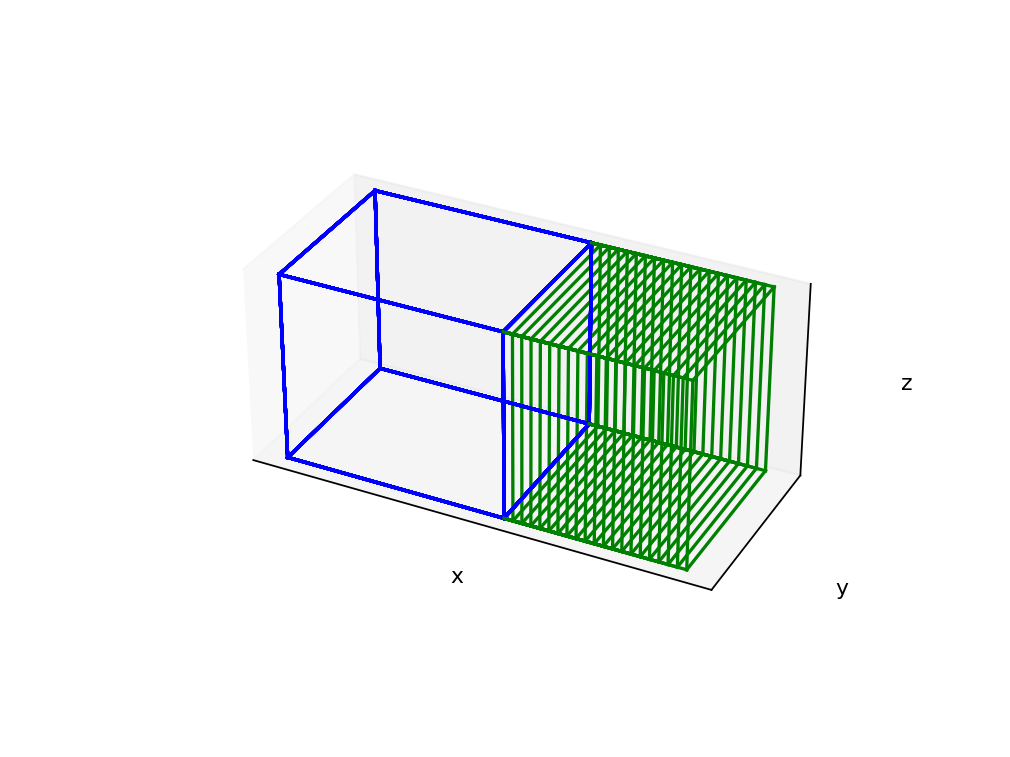

In [5]:
# Draw the box
fig = PL.drawbox_xx(xinit.magnitude,xfinal.magnitude,y.magnitude,z.magnitude)

# Draw the steps to the final box
for i in range(nsteps):
    xfinal_this_step = xinit.magnitude+i*dx.magnitude
    fig = PL.drawbox_xx(xinit.magnitude,xfinal_this_step,y.magnitude,z.magnitude,fig=fig)

### A functionalized way of computing the infinitessimal heating for a small expansion
It'll be handy to have a "functionalized" way of computing the infinitessimal heating for a small expansion. We do that in the cell below (making use of Eq. 2 of the KMTheory CGI).

In [6]:
def get_dq_kinetic_simplified(n, M, v, V, dx, A):
    ###  This is a functionalized computation of the infinitessimal heating for a small expansion. ###
    
    dV = A*dx
    dq_kinetic = n*M*v**2*dV/V
    dq_kinetic.ito('joule')
    
    return dq_kinetic

### Numerical integration of our kinetic-molecular results
Assuming we're happy with our get_dq_kinetic_simplified function, we'll put it in a loop to simulate many steps -- see Eq. 1 in the Introduction.

In [7]:
# Specify an empty array that will hold our list of infinitessimal heating for each step
dq_kinetic_array = AssignQuantity([],'joule')

# Loop over our steps, updating our starting volume and recording the heat as we go along
### BEGIN SOLUTION
for i in range(nsteps):
    
    # This finds the volume at this point in the expansion
    Vinit_this_step = Vinit + i*dx*A
    
    # Make a call to get_dq_kinetic_simplified to get dq_kinetic_this_step
    dq_kinetic_this_step = get_dq_kinetic_simplified(n, M, v, Vinit_this_step, dx, A)
    
    # This appends the heat transfer for this step to an ever-growing list of dq's
    dq_kinetic_array = np.append(dq_kinetic_array, dq_kinetic_this_step)
### END SOLUTION

# This is the numerical equivalent of integrating over all the steps (Eq. 1)
print(dq_kinetic_array)
q_kinetic_numerical = np.sum(dq_kinetic_array)
print('q_kinetic from numerical integration = ', q_kinetic_numerical)

[97.44008000000004 93.69238461538464 90.22229629629632 87.00007142857145 84.00006896551726 81.2000666666667 78.58070967741938 76.12506250000001 73.81824242424244 71.64711764705885 69.60005714285717 67.66672222222225 65.83789189189191 64.1053157894737 62.461589743589755 60.90005000000002 59.41468292682928 58.000047619047635 56.6512093023256 55.36368181818183] joule
q_kinetic from numerical integration =  1453.7273486775764 joule


### Analytical integration of our kinetic-molecular results 
In the cell below, evaluate the heat transferred using our integrated kinetic-molecular formula (based on Eq. 2).

In [8]:
### BEGIN SOLUTION
q_kinetic_analytical = n*M*v**2*np.log(Vfinal/Vinit)
q_kinetic_analytical.ito('joule')
print('q_kinetic from analytical integration = ', q_kinetic_analytical)
### END SOLUTION

q_kinetic from analytical integration =  1431.8494912748924 joule


### Pause for analysis
Calculate (and print) the difference (%) between the numerical and analytical results you just got (i.e., Eq. 1 vs Eq. 2).

In [9]:
### BEGIN SOLUTION
error = (q_kinetic_analytical-q_kinetic_numerical)/q_kinetic_analytical*100
print('Error = ', error)
### END SOLUTION

Error =  -1.5279439309786895 dimensionless


### Thermodynamic results
In the cell below, evaluate the heat transferred using our integrated thermodynamic formula (based on Eq. 3).

In [10]:
### BEGIN SOLUTION
q_thermodynamic = n*R*T*np.log(Vfinal/Vinit)
print(q_thermodynamic)
### END SOLUTION

1431.849491274892 joule


### Pause for analysis
Calculate (and print) the difference (%) between your analytical results (i.e., Eq. 2 vs Eq. 3).

By the way, in situations like this, if an error is $<10^{-10} \%$, you can assume that it is due to precision issues (like how precise Python stores floating point numbers). That is, differences that small are not meaninful.

In [11]:
### BEGIN SOLUTION

error = (q_kinetic_analytical/q_thermodynamic-1)*100
print('Error of the analytical result (%) = ', error)


### END SOLUTION

Error of the analytical result (%) =  2.220446049250313e-14 dimensionless


### Refreshing and saving your code
1. Use the dropdown menu Kernel/Restart
2. Use the dropdown menu Cell/Run All Above
3. Under the "File" dropdown menu item in the upper left is a disk icon. Press it now to save your work (you can, do this at any time as you're working on an assignment, actually).

### Validating
This step will help ensure that you didn't miss something (although it's not a guarantee). Find the "Validate" button and press it. If there are any errors or warnings, fix them.

### Finishing up
Assuming all this has gone smoothly, carry out three more steps (but read this carefully before starting):
1. Close this notebook using the "File/Close and Halt" dropdown menu
1. Using the Assignments tab, submit this notebook
1. Press the Logout tab of the Home Page